# Optimizing Factor Portfolios with Hierarchical Clustering

This notebook demonstrates the application of Hierarchical Risk Parity (HRP) to allocate weights to a portfolio of factor-based portfolios.

To get those results, we first applys HRP method to all the portfolios. Here's the set-up of this study:

- Start date/ end date: 1/1/2000 - 1/1/2024
- Universe: all factors that were known at each rebal date. (*)
- Rebalancing period: Bi-monthly
- No parameter optimization

The 3 allocation models processed here are:

- HERC
- HRP
- HARP

For each model, correlation matrices were calculated using the following lookback windows: 3, 6, 12, and 24 months. Factor-based portfolio volatility was computed with a 6-month lookback window. The HARP model's performance criterion was based on a 3-month lookback window. 

The benchmark was an equally weighted basket of all factor-based portfolios.


(*) To prevent the study from leakage, we consider that a factor portfolio is tradeable the year after it has been published.

## Load libraries

In [1]:
import os
import sys

os.chdir("../..")

cwd = os.getcwd()

for root, dirs, file in os.walk(cwd):
    sys.path.append(root)

In [2]:
cwd

'c:\\Users\\HP\\Desktop\\Work\\Projects\\factor_investing'

In [31]:
import polars as pl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from tqdm import tqdm

In [33]:
from compute_pnl import Pnl
from financial_metrics import FinMetrics
from visualize_performance import VisualizePortfolio
from utils import set_layout

In [5]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Load Data

#### Ptf infos

In [6]:
PATH_TO_DATA_FACTOR_INFOS = "data/raw_data/factor_cluster_label.csv"

df_ptf_infos = (
    pl.read_csv(PATH_TO_DATA_FACTOR_INFOS).with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
        pl.col("available_date").str.to_date(format="%Y-%m-%d"),
    )
    # .rename({"portfolio": "name", "factor": "cluster"})
)

#### Ptf returns

In [7]:
PATH_TO_DATA_FACTOR_RETURNS = "data/raw_data/us_factors_vw_daily.csv"

df_ptf_rets = (
    pl.read_csv(PATH_TO_DATA_FACTOR_RETURNS)
    .with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
    )
    .join(
        df_ptf_infos.select(["available_date", "portfolio", "factor"]), on="portfolio", how="left"
    )
)

#### Allocation data

In [8]:
PATH_TO_DATA_ALLOCATION = "data/prep_data/alloc/bounded"
ALLOCATION_METHOD = "average"

FILENAMES = (
    pl.DataFrame({"filename": os.listdir(PATH_TO_DATA_ALLOCATION)})
    .filter(pl.col("filename").str.contains(ALLOCATION_METHOD))
    .to_series()
    .sort()
    .to_list()
)

out = []
for filename in FILENAMES:
    out.append(
        pl.read_parquet(os.path.join(PATH_TO_DATA_ALLOCATION, filename))
        .select(["name", "date", "relative_weight", "cluster"])
        .with_columns(pl.lit(filename).alias("alloc_model"))
    )

df_alloc = pl.concat(out)

In [9]:
PATH_TO_BENCH_DATA = os.path.join(PATH_TO_DATA_ALLOCATION, "benchmark")

df_weights_benchmark_to_pnl = pl.read_parquet(PATH_TO_BENCH_DATA)

## PnL Computation

In [10]:
START_DATE_PNL = dt.date(2000, 1, 1)
END_DATE_PNL = dt.date(2024, 1, 1)

WINDOWS = [3, 6, 12, 24]

FREQ = 252
CUMPROD = False
VOL_TARGET = 0.1 / 252**0.5

metric_obj = FinMetrics(frequency=FREQ, cumprod=CUMPROD, vol_target=VOL_TARGET)

visualize_obj = VisualizePortfolio(frequency=FREQ, cumprod=CUMPROD, vol_target=VOL_TARGET)

### Benchmark

In [11]:
pnl_obj_bench = Pnl(
    df_rets=df_ptf_rets,
    df_weights=df_weights_benchmark_to_pnl,
    start_date=START_DATE_PNL,
    end_date=END_DATE_PNL,
)

df_pnl_bench = pnl_obj_bench.get_pnl()

# df_pnl_bench

In [12]:
dates_pnl = df_pnl_bench.select(["date"])

In [13]:
df_metrics_bench = metric_obj.compute_summary_stats(
    returns=df_pnl_bench.to_pandas().set_index("date")
)
df_metrics_bench.columns = ["bench"]
df_metrics_bench.round(2)

,bench
arithmetic_return,6.50
geometric_return,6.18
volatility,10.00
sharpe_ratio,0.65
modified_sharpe_ratio,0.62
maximum_drawdown,18.84
maximum_time_under_water,1697.00
terminal_wealth,2.55
nr_observations,6032.00


### HERC Models

In [14]:
pnl_herc = {}

for window in tqdm(WINDOWS):
    df_weight_temp = df_alloc.filter(
        pl.col("alloc_model").str.contains("hrp"),
        ~pl.col("alloc_model").str.contains("risk"),
        pl.col("alloc_model").str.contains(f"sim_{window}"),
    ).rename({"name": "portfolio", "cluster": "factor"})

    pnl_obj_bench_temp = Pnl(
        df_rets=df_ptf_rets,
        df_weights=df_weight_temp,
        start_date=START_DATE_PNL,
        end_date=END_DATE_PNL,
    )

    df_pnl_herc_temp = pnl_obj_bench_temp.get_pnl()

    pnl_herc[f"herc_{window}"] = df_pnl_herc_temp

100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


In [15]:
df_metrics = df_metrics_bench
for k, v in pnl_herc.items():
    df_metric_herc_temp = metric_obj.compute_summary_stats(returns=v.to_pandas().set_index("date"))
    df_metric_herc_temp.columns = [k]
    df_metrics = pd.concat([df_metrics, df_metric_herc_temp], axis=1)
df_metrics.round(2)

,bench,herc_3,herc_6,herc_12,herc_24
arithmetic_return,6.50,6.91,5.67,5.44,7.75
geometric_return,6.18,6.62,5.30,5.07,7.52
volatility,10.00,10.00,10.00,10.00,10.00
sharpe_ratio,0.65,0.69,0.57,0.54,0.78
modified_sharpe_ratio,0.62,0.66,0.53,0.51,0.75
maximum_drawdown,18.84,21.14,18.50,19.16,16.81
maximum_time_under_water,1697.00,861.00,1299.00,1727.00,720.00
terminal_wealth,2.55,2.66,2.36,2.30,2.86
nr_observations,6032.00,6032.00,6032.00,6032.00,6032.00


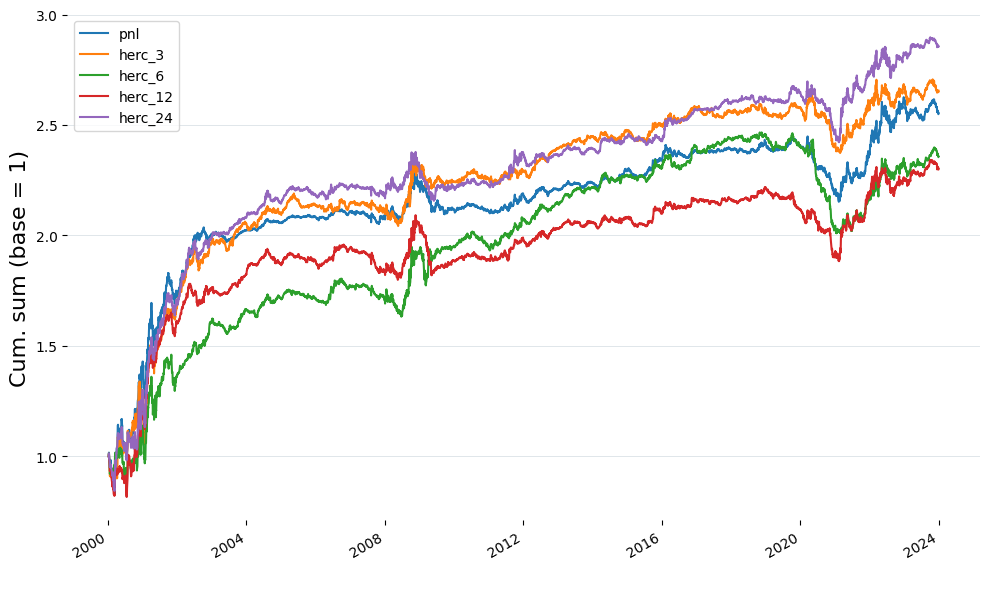

In [16]:
ret_to_plot = [df_pnl_bench.to_pandas().set_index("date")] + [
    df.rename({"pnl": f"{alloc_model}"}).to_pandas().set_index("date")
    for alloc_model, df in pnl_herc.items()
]

visualize_obj.plot_portfolios(returns=ret_to_plot)

### HRP Models

In [17]:
pnl_hrp = {}

for window in tqdm(WINDOWS):
    df_weight_temp = df_alloc.filter(
        pl.col("alloc_model").str.contains("hrp"),
        pl.col("alloc_model").str.contains("risk"),
        pl.col("alloc_model").str.contains(f"sim_{window}"),
    ).rename({"name": "portfolio", "cluster": "factor"})

    pnl_obj_hrp_temp = Pnl(
        df_rets=df_ptf_rets,
        df_weights=df_weight_temp,
        start_date=START_DATE_PNL,
        end_date=END_DATE_PNL,
    )

    df_pnl_hrp_temp = pnl_obj_hrp_temp.get_pnl()

    pnl_hrp[f"hrp_{window}"] = df_pnl_hrp_temp

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


In [18]:
df_metrics_hrp = df_metrics_bench
for k, v in pnl_hrp.items():
    df_metric_hrp_temp = metric_obj.compute_summary_stats(returns=v.to_pandas().set_index("date"))
    df_metric_hrp_temp.columns = [k]
    df_metrics_hrp = pd.concat([df_metrics_hrp, df_metric_hrp_temp], axis=1)
df_metrics_hrp.round(2)

,bench,hrp_3,hrp_6,hrp_12,hrp_24
arithmetic_return,6.50,6.43,7.68,6.82,7.62
geometric_return,6.18,6.11,7.44,6.53,7.38
volatility,10.00,10.00,10.00,10.00,10.00
sharpe_ratio,0.65,0.64,0.77,0.68,0.76
modified_sharpe_ratio,0.62,0.61,0.74,0.65,0.74
maximum_drawdown,18.84,14.64,15.45,17.82,15.18
maximum_time_under_water,1697.00,1772.00,1775.00,2034.00,1201.00
terminal_wealth,2.55,2.54,2.84,2.63,2.82
nr_observations,6032.00,6032.00,6032.00,6032.00,6032.00


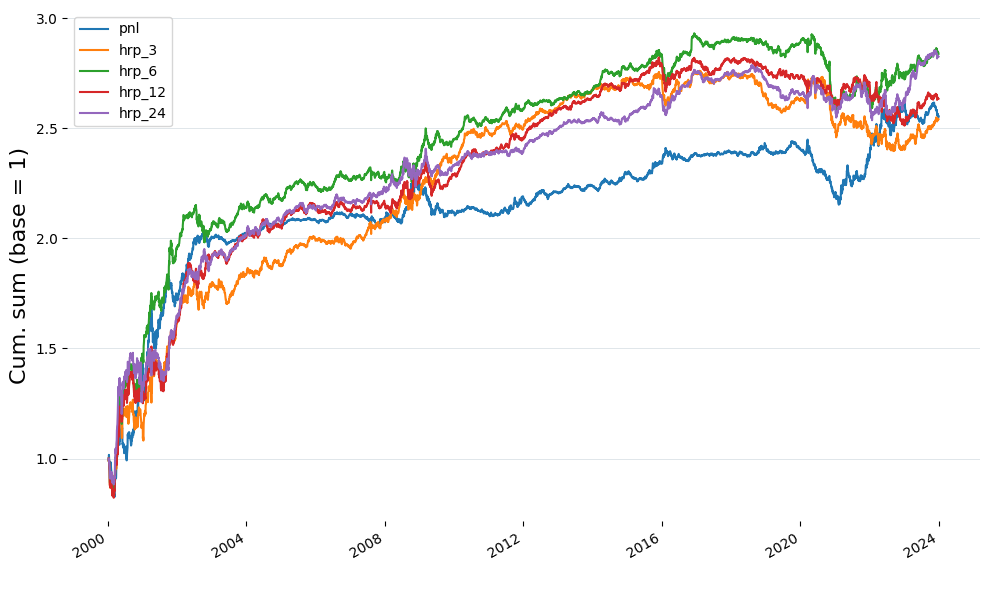

In [19]:
ret_to_plot = [df_pnl_bench.to_pandas().set_index("date")] + [
    df.rename({"pnl": f"{alloc_model}"}).to_pandas().set_index("date")
    for alloc_model, df in pnl_hrp.items()
]

visualize_obj.plot_portfolios(returns=ret_to_plot)

### HARP Models

In [20]:
pnl_harp = {}

for window in tqdm(WINDOWS):
    df_weight_temp = df_alloc.filter(
        pl.col("alloc_model").str.contains("harp"),
        pl.col("alloc_model").str.contains(f"sim_{window}"),
    ).rename({"name": "portfolio", "cluster": "factor"})

    pnl_obj_harp_temp = Pnl(
        df_rets=df_ptf_rets,
        df_weights=df_weight_temp,
        start_date=START_DATE_PNL,
        end_date=END_DATE_PNL,
    )

    df_pnl_harp_temp = pnl_obj_harp_temp.get_pnl()

    pnl_harp[f"harp_{window}"] = df_pnl_harp_temp

100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


In [21]:
df_metrics_harp = df_metrics_bench
for k, v in pnl_harp.items():
    df_metric_harp_temp = metric_obj.compute_summary_stats(returns=v.to_pandas().set_index("date"))
    df_metric_harp_temp.columns = [k]
    df_metrics_harp = pd.concat([df_metrics_harp, df_metric_harp_temp], axis=1)
df_metrics_harp.round(2)

,bench,harp_3,harp_6,harp_12,harp_24
arithmetic_return,6.50,6.54,5.66,5.00,7.18
geometric_return,6.18,6.23,5.29,4.60,6.90
volatility,10.00,10.00,10.00,10.00,10.00
sharpe_ratio,0.65,0.65,0.57,0.50,0.72
modified_sharpe_ratio,0.62,0.62,0.53,0.46,0.69
maximum_drawdown,18.84,18.97,20.04,20.83,14.44
maximum_time_under_water,1697.00,814.00,914.00,1673.00,1364.00
terminal_wealth,2.55,2.57,2.35,2.20,2.72
nr_observations,6032.00,6032.00,6032.00,6032.00,6032.00


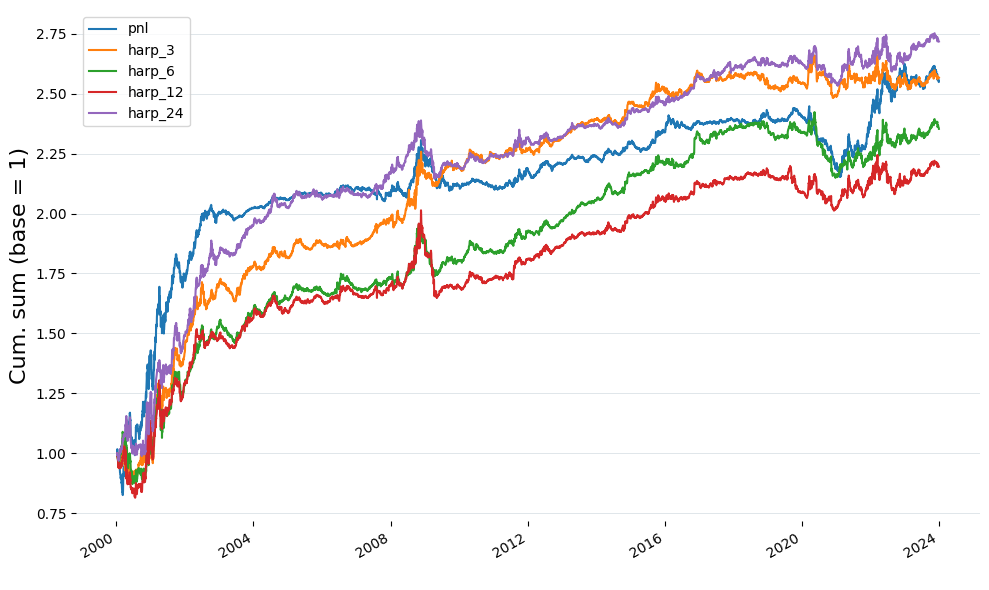

In [22]:
ret_to_plot = [df_pnl_bench.to_pandas().set_index("date")] + [
    df.rename({"pnl": f"{alloc_model}"}).to_pandas().set_index("date")
    for alloc_model, df in pnl_harp.items()
]

visualize_obj.plot_portfolios(returns=ret_to_plot)

### Global Model

The global model is composed of an equal weighted allocation between all the allocation models ploted before.

In [23]:
pnls = [(pnl_herc, "pnl_glob_herc"), (pnl_hrp, "pnl_glob_hrp"), (pnl_harp, "pnl_glob_harp")]

glob_pnl_per_alloc_model = []

for pnl, model_name in pnls:
    glob_pnl_per_alloc_model.append(
        (
            pl.concat(
                [
                    df_pnl.select(["pnl"]).rename({"pnl": f"{alloc_model}"})
                    for alloc_model, df_pnl in pnl.items()
                ],
                how="horizontal",
            )
            .with_columns(
                (pl.sum_horizontal(pl.all()).truediv(len(WINDOWS)).alias(f"{model_name}"))
            )
            .select([f"{model_name}"])
        )
    )

df_pnl_global = pl.concat([dates_pnl] + glob_pnl_per_alloc_model, how="horizontal").with_columns(
    pl.sum_horizontal(pl.all().exclude("date"))
    .truediv(len(glob_pnl_per_alloc_model))
    .alias("pnl_glob")
)

In [24]:
ALLOC_MODEL_METRIC = ["pnl_glob_herc", "pnl_glob_hrp", "pnl_glob_harp", "pnl_glob"]


df_glob_metric = df_metrics_bench

for alloc_model in ALLOC_MODEL_METRIC:
    df_metric_temp = metric_obj.compute_summary_stats(
        returns=df_pnl_global.select(["date", alloc_model]).to_pandas().set_index("date")
    )
    df_metric_temp.columns = [f"{alloc_model.split("_")[-1]}"]
    df_glob_metric = pd.concat([df_glob_metric, df_metric_temp], axis=1)

df_glob_metric.round(2)

,bench,herc,hrp,harp,glob
arithmetic_return,6.50,7.21,8.18,6.52,8.78
geometric_return,6.18,6.93,7.98,6.20,8.63
volatility,10.00,10.00,10.00,10.00,10.00
sharpe_ratio,0.65,0.72,0.82,0.65,0.88
modified_sharpe_ratio,0.62,0.69,0.80,0.62,0.86
maximum_drawdown,18.84,15.36,16.65,15.26,12.03
maximum_time_under_water,1697.00,771.00,1775.00,1103.00,962.00
terminal_wealth,2.55,2.72,2.96,2.56,3.10
nr_observations,6032.00,6032.00,6032.00,6032.00,6032.00


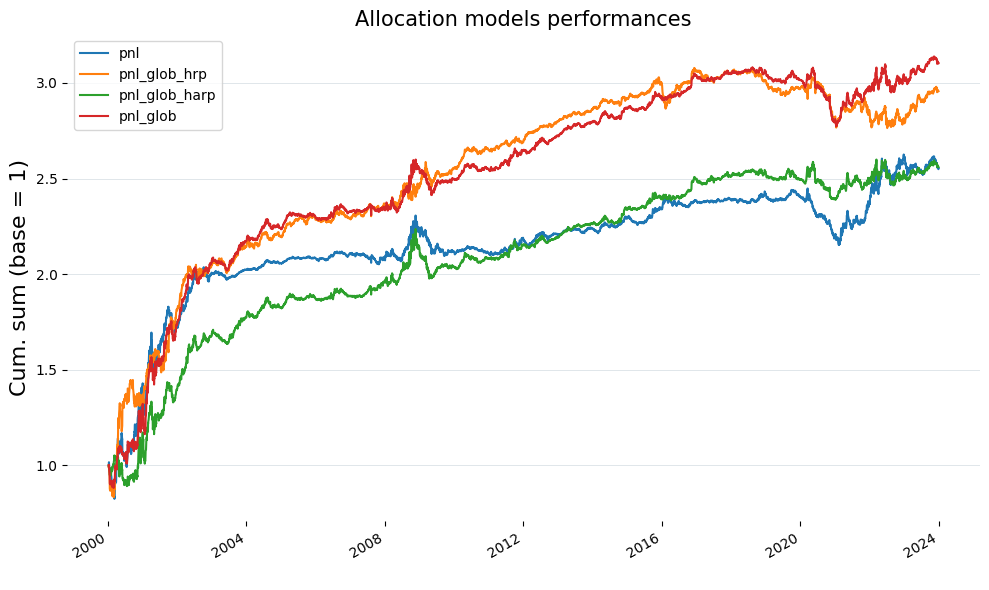

In [25]:
df_to_plot = df_pnl_global.to_pandas().set_index("date")

ret_to_plot = [
    df_pnl_bench.to_pandas().set_index("date"),
    df_to_plot.loc[:, ["pnl_glob_hrp"]],
    df_to_plot.loc[:, ["pnl_glob_harp"]],
    df_to_plot.loc[:, ["pnl_glob"]],
]

visualize_obj.plot_portfolios(returns=ret_to_plot, title="Allocation models performances")

<Axes: title={'center': 'Yearly performance of all allocation model'}, xlabel='date', ylabel='Returns'>

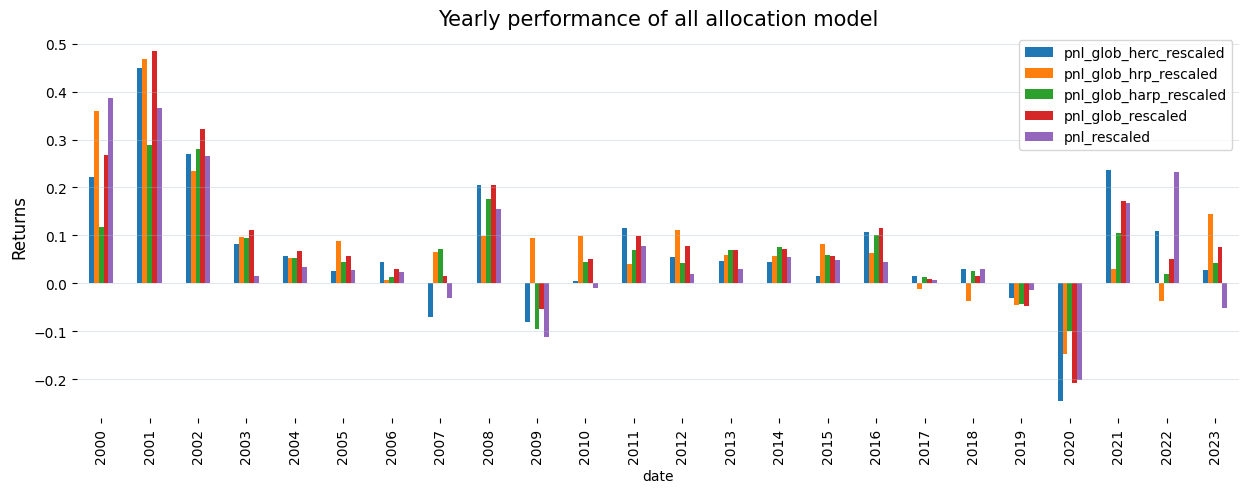

In [44]:
df_pnl_glob_rescaled = (
    df_pnl_global.join(df_pnl_bench, on="date", how="left")
    .with_columns(
        ((VOL_TARGET / pl.all().exclude("date").std()) * pl.all().exclude("date")).name.suffix(
            "_rescaled"
        )
    )
    .select(["date", "^.*rescaled.*$"])
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

df_pnl_glob_rescaled.group_by(pl.col("date").dt.year()).agg(pl.all().mean() * FREQ).sort(
    "date"
).to_pandas().plot.bar(x="date", ax=ax)
ax.set_title("Yearly performance of all allocation model", size=15)
ax.set_ylabel("Returns", size=12)
set_layout(ax=ax)

<b> As we can see, the aggregate allocation model outperforms the benchmark in all metrics. Instead of just enhancing the overall performance by ~2% per year, it also help to reduce the maximum drawdown and the time underwater, which are two key metrics for investors. </b>

The conclusion is here that without any optimization, we are able to outperform an equal weighted basket of all factor-based protfolios by just applying the diversification principle. 

To go further, and enhance the performance of the global model, here's what we can do:
- try to optimize the different hyperparameters exposed at the begining of the notebook (*)
- <b> try to overweight/underweight each allocation model instead of equal weighting them (**) </b>


(*) For the moment, all the parameters used are just selected with a "logical" think

(**) <b>  Idea is here to train a Reinforcement Learning agent and find an optimal policy to underweight/overweight all the allocation model (HRP [3, 6, 12, 24] & HARP [3, 6, 12, 24]).  (Work is in progress on this idea) </b>
